In [ ]:
class PlanetParams(v.Menu, sw.SepalWidget):
    
    def __init__(self, *args, **kwargs):
        
        self.offset_y = True
        self.close_on_content_click = False
        
        super().__init__(*args, **kwargs)
        
        self.btn = sw.Btn(
            v_on='menu.on', 
        )
        
        
        self.close = sw.Btn()
        
        self.v_slots = [{
            'name': 'activator',
            'variable': 'menu',
            'children': self.btn
        }]
        
        self.children=[
            v.Card(children=[
                v.CardTitle(children=['Children']),
                v.CardText(children=['asdfasdfadsfasdfsda']),
                self.close
            ])
        ]
        
        self.btn.on_event('click', self.close)
    
    def close(self, *args):
        self.v_model = False

In [ ]:
pp = PlanetParams()

In [ ]:
v.Card(children=[pp])

In [1]:
import datetime
import pandas as pd

In [2]:
import sepal_ui.sepalwidgets as sw

Styles()

ResizeTrigger()

In [3]:
from pathlib import Path

In [4]:
from component.parameter import *


In [5]:
w_start = sw.DatePicker(label='Start date (inclusive)')

In [6]:
w_start

DatePicker(align_center=True, children=[Flex(children=[Menu(children=[DatePicker(no_title=True, scrollable=Tru…

In [7]:
w_end = sw.DatePicker(label='Start date (inclusive)')
w_end

DatePicker(align_center=True, children=[Flex(children=[Menu(children=[DatePicker(no_title=True, scrollable=Tru…

In [8]:
def get_historical_alerts(start, end):
    

    from urllib.request import urlretrieve
    from pathlib import Path
    from zipfile import ZipFile
    import pandas as pd
    from datetime import datetime
    
    """Get historical alerts

    Args:
        start (sw.DatePicker.v_model)
        end (sw.DatePicker.v_model)
    """

    start = datetime.strptime(start, '%Y-%m-%d')
    end = datetime.strptime(end, '%Y-%m-%d')                

    # Validate y2 >= y1

    if end < start:
        raise Exception('End date must be older than starting')


    # Get unique year(s)
    years = list(range(start.year, end.year+1))
    
    # Download all the fires between the given dates
    all_dfs = []
    for y in years:
        
        # Verify if the files is not previously downloaded
        out_file = HISTORIC_DIR/f'historic_fires_{y}.zip'

        if not out_file.exists():
            urlretrieve(HISTORIC_URL.format(y), out_file)
            
        # Open all fires into the zipped files and merge 
        # thme into one single DataFrame

        zip_file = ZipFile(out_file)
        dfs = pd.concat([
            pd.read_csv(zip_file.open(text_file.filename))
            for text_file in zip_file.infolist()
            if text_file.filename.endswith('.csv')
        ])
        all_dfs.append(dfs)
    
    dfs = pd.concat(all_dfs)
    
    # Filter them with its date
    dfs.acq_date = pd.to_datetime(dfs.acq_date)
    
    return dfs[(dfs.acq_date>=start) & (dfs.acq_date<=end)]

In [9]:
dfs = get_historical_alerts(w_start.v_model, w_end.v_model)

In [10]:
import geopandas as gpd

In [11]:
%%time
alerts_gdf = gpd.GeoDataFrame(
    dfs, 
    geometry=gpd.points_from_xy(dfs.longitude, dfs.latitude), 
    crs="EPSG:4326"
)

CPU times: user 8.4 s, sys: 58.5 ms, total: 8.46 s
Wall time: 8.46 s


In [20]:
from component.tiles.aoi_tile import *

HTML(value='\n<style>\nbody.jp-Notebook, \ndiv.jp-Cell,\ndiv.jp-OutputArea-output {\n\n    margin: 0 !importan…

In [21]:
aoi_tile = AoiTile()

In [22]:
aoi_tile

AoiTile(children=[AoiView(children=[MethodSelect(dense=True, items=[{'header': 'Administrative definitions'}, …

In [33]:
clip_geometry = aoi_tile.view.model.gdf.iloc[0].geometry
clip_geometry

In [34]:
clip_geometry = clip_geometry.simplify(0.6)

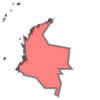

In [35]:
clip_geometry

In [12]:
COUNTRIES = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json')

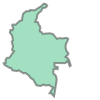

In [37]:
country_df = COUNTRIES[COUNTRIES['name']=='Colombia']
clip_geometry =  country_df.iloc[0].geometry
clip_geometry

In [38]:
%%time
alerts_clip = alerts_gdf[alerts_gdf.geometry.intersects(clip_geometry)]

CPU times: user 4.63 s, sys: 24 ms, total: 4.65 s
Wall time: 4.63 s


In [15]:
alerts_clip

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,geometry
491,0.5166,-70.0509,312.6,1.1,1.0,2020-01-05,1809,Aqua,MODIS,56,6.03,299.1,5.8,D,0,POINT (-70.05090 0.51660)
497,1.7136,-69.4129,324.7,1.0,1.0,2020-01-05,1809,Aqua,MODIS,78,6.03,298.7,16.1,D,0,POINT (-69.41290 1.71360)
893,1.7133,-69.4131,323.6,1.4,1.2,2020-01-07,1757,Aqua,MODIS,43,6.03,299.4,23.7,D,0,POINT (-69.41310 1.71330)
894,1.7307,-69.4411,327.0,1.4,1.2,2020-01-07,1757,Aqua,MODIS,79,6.03,299.3,28.9,D,0,POINT (-69.44110 1.73070)
895,1.7354,-69.4474,328.2,1.4,1.2,2020-01-07,1757,Aqua,MODIS,82,6.03,298.3,33.7,D,0,POINT (-69.44740 1.73540)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22894,5.6160,-67.5821,307.5,1.0,1.0,2020-02-29,259,Terra,MODIS,72,6.03,297.0,3.9,N,0,POINT (-67.58210 5.61600)
22895,5.6771,-67.5418,310.7,1.0,1.0,2020-02-29,259,Terra,MODIS,80,6.03,297.2,6.1,N,0,POINT (-67.54180 5.67710)
23323,5.6919,-67.5570,320.9,1.4,1.2,2020-02-29,1517,Terra,MODIS,50,6.03,299.7,11.8,D,0,POINT (-67.55700 5.69190)
23347,5.4144,-67.6623,327.4,1.3,1.1,2020-02-29,1817,Aqua,MODIS,28,6.03,302.9,16.4,D,0,POINT (-67.66230 5.41440)
